In [1]:
import sys; sys.path.insert(0, '..')
from database.dataset import *
import pyforest
import matplotlib.pyplot as plt
plt.style.use('default')
import cv2
from math import sqrt
from tqdm import tqdm
from scipy.ndimage import gaussian_filter
from skimage.feature import blob_dog, hessian_matrix,hessian_matrix_eigvals

In [2]:
db = INBreast_Dataset(
        return_lesions_mask=True,
        level='image',
        extract_patches=False,
        normalize=None,
        n_jobs=-1,
)


In [3]:
list_img = [db[i]['img'] for i in range(10)]

#### Plot functions

In [4]:
def plot_img_rois(index: int, colors = ['yellow','orange'], linewidth = 1,radius = 6):
    """
    Plots the original image with rois as markers. Rectangles for rois with bounding boxes
    and circles with given radius for point lesions. Both markers with given linewidth and colors.

    Args:
        index (int): index of item in the database instance INBreast_Dataset
        colors (list, optional): color of the marker [rectangles, circles]. Defaults to ['yellow','orange'].
        linewidth (int, optional): width of line. Defaults to 1.
        radius (int, optional): radius of circles. Defaults to 6.
    """
    f,ax = plt.subplots(1,2,figsize=(10,8))
    ax[0].imshow(db[index]['img'],cmap='gray') # display image
    
    lesion_bbxs = [[bbox[0],bbox[1][0]-bbox[0][0],bbox[1][1]-bbox[0][1]] \
         for bbox in db[index]['lesion_bboxes'] if bbox[0] != bbox[1]] # get lesion boxes

    lesion_pts = [bbox[0] for bbox in db[index]['lesion_bboxes'] if bbox[0] == bbox[1]] # get lesion points
    
    for coords,width,height in lesion_bbxs:
        rec = plt.Rectangle(coords, width=width, height=height, color=colors[0], linewidth=linewidth, fill=False)
        ax[0].add_patch(rec)
    for coords in lesion_pts:
        c = plt.Circle(coords, radius=radius, color=colors[1], linewidth=linewidth, fill=False)
        ax[0].add_patch(c)
    ax[0].set_title('Image with ROIs')
    ax[0].axis('off')
    ax[1].imshow(db[index]['lesion_mask'])
    ax[1].set_title('Image mask')
    ax[1].axis('off')
    plt.tight_layout()
    plt.show()

In [5]:
def easy_plot(i: int):
    """Plots the original image and mask, of instance INBreast_Dataset

    Args:
        i (int): index of item
    """
    f,ax = plt.subplots(1,2,figsize=(8,6))
    ax[0].imshow(db[i]['img'], cmap='gray' )
    ax[1].imshow(db[i]['lesion_mask'])
    ax[0].axis('off')
    ax[1].axis('off')
    plt.show()

In [6]:
def gaus_plot(i,img_gaus):
    f,ax = plt.subplots(1,2,figsize=(8,6))
    ax[0].imshow(db[i]['img'], cmap='gray' )
    ax[1].imshow(img_gaus,cmap='gray')
    ax[0].axis('off')
    ax[1].axis('off')
    plt.show()

In [7]:
import seaborn as sns

def plot_img_hist(img):
    fig, ax = plt.subplots(1, 2, figsize=(15, 10))
    ax[0].imshow(img,cmap='gray')
    sns.histplot(img.flatten(), ax=ax[1], bins=1000, element='poly', alpha=0.2)
    ax[1].set_yscale("log")

In [8]:
def plot_blobs(image,image_blobs):
    f,ax = plt.subplots(1,1,figsize=(10,10))
    ax.imshow(image,cmap='gray')
    for blob in tqdm(image_blobs):
        y,x,r = blob
        c = plt.Circle((x, y), r, color='yellow', linewidth=1, fill=False)
        ax.add_patch(c)
    plt.axis('off')
    plt.tight_layout()
    plt.show()

#### Metric functions

In [9]:
def circle_comparison(true_bboxes, predicted_roi_circles, mask):
    """Finds TP, FP and number of FN for a prediction of circles given image mask

    Args:
        true_bboxes (np.ndarray): Array of shape (n_rois, 2) containing
            tl and br bbox coordinates in tuples
        predicted_roi_circles (np.ndarray): Array of shape (n_predicted_circ, 3)
            with circle_x, circle_y and circle_radius values
        mask (np.ndarray): Image mask containing indexes of rois

    Returns:
        TP (set): contains TP roi indexes
        FP (set): contains FP circle indexes (that weren't mapped to any rois)
        FN (int): number of rois not mapped to any of the predicted circles
    """
    TP = set()
    FP = []

    true_mask = mask

    for circle_idx, circle in enumerate(tqdm(predicted_roi_circles.astype(int))):
        circle_roi_mask=cv2.circle(np.zeros(mask.shape),
                                     (circle[0], circle[1]),
                                     circle[2], 1, -1).astype(np.bool8)

        mapped_rois_idxs=set(
            np.unique(true_mask[circle_roi_mask])).difference(set([0]))
        if len(mapped_rois_idxs) > 0:
            TP = TP.union(mapped_rois_idxs)
        else:
            FP.append(circle_idx)
    FN = len(true_bboxes) - len(TP)
    return TP, FP, FN

In [10]:
def quick_circle_comparison(true_bboxes, predicted_roi_circles, mask, n_jobs=6):
    """Finds TP, FP and number of FN for a prediction of circles given image mask

    Args:
        true_bboxes (np.ndarray): Array of shape (n_rois, 2) containing
            tl and br bbox coordinates in tuples
        predicted_roi_circles (np.ndarray): Array of shape (n_predicted_circ, 3)
            with circle_x, circle_y and circle_radius values
        mask (np.ndarray): Image mask containing indexes of rois

    Returns:
        TP (set): contains TP roi indexes
        FP (int): contains FP circle indexes (thate weren't mapped to any rois)
        FN (int): number of rois not mapped to any of the predicted circles
    """
    TP = []
    FP = 0
    FN = 0
    
    for circle in predicted_roi_circles.astype(int):
        cricle_tl = (max(0, circle[0] - circle[2]), max(0, circle[1] - circle[2]))
        circle_br = (min(mask.shape[1], circle[0] + circle[2]), min(mask.shape[0], circle[1] + circle[2]))
        
        intersected_mask_idxs = np.unique(mask[cricle_tl[1]:circle_br[1], cricle_tl[0]:circle_br[0]])
        if intersected_mask_idxs.sum()>0:
            TP.extend(intersected_mask_idxs)
        else:
            FP+=1
    TP = set(np.unique(TP)).difference(set([0]))
    FN = len(true_bboxes) - len(TP)
    return TP, FP, FN

### Pipe 1

In [11]:
def norm_image(image):
    return (image-image.min())/(image.max()-image.min()) # image normalization

In [13]:
def cal_det_se(no_tp,no_fn):
    return no_tp/(no_tp+no_fn)

def fp_per_unit_area(image_shape,no_fp):
    return no_fp/(image_shape[0] * image_shape[1] * (0.070**2)/100)

 """Process image to get candidate blobs of microcalcifications with HDoG altorithm from
    MARASINOU et al. (2021):SEGMENTATION OF BREAST MICROCALCIFICATIONS: A MULTI-SCALE APPROACH

    Args:
        image (np.ndarray): mammogram image

    Returns:
        img_binary_blobs (np.ndarray): binary image of candidate blobs
        blobs_filtered (list): list of blobs coordinates and associated sigma [r(int),c(int),sigma(float)]

In [15]:
def get_image_blobs(image: np.ndarray,h_thr = 1.4):
    """Process image to get candidate blobs of microcalcifications with HDoG altorithm from
    MARASINOU et al. (2021):SEGMENTATION OF BREAST MICROCALCIFICATIONS: A MULTI-SCALE APPROACH

    Args:
        image (np.ndarray): mammogram image
        h_thr (float, optional): hessian threshold. Defaults to 1.4.

    Returns:
        img_binary_blobs (np.ndarray): binary mask of detected blobs
        blobs_filtered (list[(int),(int),(float)]): list of detected blobs [(row_coord),(col_coord),(sigma)]
    """
    # set parameters
    sigma_ratio = 1.05
    n_scales = 20
    max_sigma = 3.1
    min_sigma = 1.18
    t_dog = 0.006
    overlap_dog = 1
    h_eig_thr = 0

    # normalize image
    image = norm_image(image)

    # set sigmas of scale-space
    sigma_array = np.array([min_sigma*(sigma_ratio**n) for n in range(n_scales+1)]) 

    # get gaussian-blurr images
    gaussian_images = [gaussian_filter(image, s, mode='reflect') for s in sigma_array] 

    # get normalized difference of gaussians
    sf = 1/(sigma_ratio-1)
    img_dog = [sf*(gaussian_images[i] - gaussian_images[i+1]) for i in range(n_scales)] 
    img_dog = np.asarray(img_dog)

    # compute hessian of dog scale-space and get binary mask from condition
    img_hdog_filter = []
    
    for sigma_idx,dog in enumerate(img_dog):
        H_elems = hessian_matrix(dog,sigma=sigma_array[sigma_idx],mode='constant') 
        trace = H_elems[0] + H_elems[2]
        det = (H_elems[0]*H_elems[2]) - H_elems[1]**2 
        hessian_mask = ((trace < 0) & ((det < 0) | (np.abs(det)/(trace**2) <= h_thr)))
        img_hdog_filter.append(hessian_mask)
        
    img_hdog_filter = np.asarray(img_hdog_filter)

    # extract blobs from dog scale-space maxima
    img_blobs = blob_dog(image,min_sigma=min_sigma,max_sigma=max_sigma,sigma_ratio=sigma_ratio,threshold=t_dog,overlap=overlap_dog)
    
    # Select blobs 
    blobs_filtered = []
    blob_coords = img_blobs[:,:2].astype(int)

    for blob_index,blob_sigma in enumerate(img_blobs[:,2]):
        hess_mask = img_hdog_filter[np.where(sigma_array == blob_sigma)][0]
        if hess_mask[blob_coords[blob_index][0],blob_coords[blob_index][1]]:
            blobs_filtered.append([blob_coords[blob_index][0],blob_coords[blob_index][1],blob_sigma]) 

    # print(f'No. of blobs: {img_blobs.shape[0]}')
    # print(f'No. of blobs after hessian condition: {np.shape(blobs_filtered)[0]}')


    # create binary mask
    img_binary_blobs = np.zeros(image.shape)

    for blob in blobs_filtered:
        img_binary_blobs = cv2.circle(img_binary_blobs,(blob[1],blob[0]),int(blob[2]*sqrt(2)),255,-1)
    
    return img_binary_blobs, blobs_filtered


In [14]:
def get_image_blobs_2(image: np.ndarray):
    """Process image to get candidate blobs of microcalcifications with HDoG altorithm (modified version)

    Args:
        image (np.ndarray): mammogram image

    Returns:
        img_binary_blobs (np.ndarray): binary image of candidate blobs
        blobs_filtered (list): list of blobs coordinates and associated sigma [r(int),c(int),sigma(float)]
    """
    # set parameters
    sigma_ratio = 1.05
    n_scales = 21
    max_sigma = 3.1
    min_sigma = 1.18
    t_dog = 0.006
    overlap_dog = 1
    divider = 500

    # normalize image
    image = norm_image(image) #*(2**8)).astype(np.uint8) #(norm_image(image)*(2**8)).astype(np.uint8) 

    # set sigmas of scale-space
    sigma_array = np.array([min_sigma*(sigma_ratio**n) for n in range(n_scales+1)]) 

    # get gaussian-blurr images
    gaussian_images = [gaussian_filter(image, s, mode='reflect') for s in sigma_array] 

    # get normalized difference of gaussians
    sf = 1/(sigma_ratio-1)
    img_dog = [sf*(gaussian_images[i] - gaussian_images[i+1]) for i in range(n_scales)] 
    img_dog = np.asarray(img_dog)

    # compute hessian and eigenvalues of dog scale-space
    img_eigenvalues = []
    for sigma_idx,dog in enumerate(img_dog):
        H_elems = hessian_matrix(dog,sigma=sigma_array[sigma_idx],mode='constant') #
        eigenvalues = hessian_matrix_eigvals(H_elems)
        img_eigenvalues.append(eigenvalues)
    img_eigenvalues = np.asarray(img_eigenvalues)
    
    # Get condition and create hessian mask  
    img_hdog_filter = []
    for idx in range(img_eigenvalues.shape[0]-1):
        eig1_ms = img_eigenvalues[idx][0] * img_eigenvalues[idx+1][0] 
        eig2_ms = img_eigenvalues[idx][1] * img_eigenvalues[idx+1][1] 
        thrs_1 = np.max(eig1_ms)/divider
        thrs_2 = np.max(eig2_ms)/divider
        hessian_mask = (eig1_ms > thrs_1) & (eig2_ms > thrs_2)
        img_hdog_filter.append(hessian_mask)
    img_hdog_filter = np.asarray(img_hdog_filter)

    # extract blobs from dog scale-space maxima
    img_blobs = blob_dog(image,min_sigma=min_sigma,max_sigma=max_sigma,sigma_ratio=sigma_ratio,threshold=t_dog,overlap=overlap_dog)
    
    # Select blobs 
    blobs_filtered = []
    blob_coords = img_blobs[:,:2].astype(int)

    for blob_index,blob_sigma in enumerate(img_blobs[:,2]):
        hess_mask = img_hdog_filter[np.where(sigma_array == blob_sigma)][0]
        if hess_mask[blob_coords[blob_index][0],blob_coords[blob_index][1]]:
            blobs_filtered.append([blob_coords[blob_index][0],blob_coords[blob_index][1],blob_sigma]) 

    print(f'No. of blobs: {img_blobs.shape[0]}')
    print(f'No. of blobs after hessian condition: {np.shape(blobs_filtered)[0]}')


    # create binary mask
    img_binary_blobs = np.zeros(image.shape)

    for blob in blobs_filtered:
        img_binary_blobs = cv2.circle(img_binary_blobs,(blob[1],blob[0]),int(blob[2]*sqrt(2)),255,-1)
    
    return img_binary_blobs, blobs_filtered,img_blobs.shape[0],np.shape(blobs_filtered)[0]


In [15]:
h_thr_list = [0.40, 0.35, 0.30, 0.25, 0.20, 0.15]

In [ ]:
img_idx = 0
h_thr_list = np.linspace(.25,.19,5)
for h_thr in h_thr_list:
    img_mask,blob_list= get_image_blobs(list_img[img_idx],h_thr=h_thr)
    
    blob_list_arr = np.array(blob_list.copy())
    blob_list_arr[:,2] = blob_list_arr[:,2]*sqrt(2)
    blob_list_arr[:,[0, 1]] = blob_list_arr[:,[1, 0]]
    TP, FP, FN = quick_circle_comparison(db[img_idx]['lesion_bboxes'],(blob_list_arr).astype(int),db[img_idx]['lesion_mask'])
    
    print(f'{h_thr} SE: {cal_det_se(len(TP),FN)},FPpua: {fp_per_unit_area(img_mask.shape,FP)}')
    

In [18]:
# img_idx = 0
h_thr_list = [1.14, 0.3, 0.25, 0.24, 0.23]#np.linspace(.25,.19,5)
for img_idx in range(1,5):
    for h_thr in h_thr_list:
        img_mask,blob_list,no_blobs,no_blobs_filtered= get_image_blobs(db[img_idx]['img'],h_thr=h_thr)
        
        blob_list_arr = np.array(blob_list.copy())
        blob_list_arr[:,2] = blob_list_arr[:,2]*sqrt(2)
        blob_list_arr[:,[0, 1]] = blob_list_arr[:,[1, 0]]
        TP, FP, FN = quick_circle_comparison(db[img_idx]['lesion_bboxes'],(blob_list_arr).astype(int),db[img_idx]['lesion_mask'])
        
        print(f'Img: {img_idx}, h_thr: {h_thr} SE: {cal_det_se(len(TP),FN)},FPpua: {fp_per_unit_area(img_mask.shape,FP)}')
        print(f'    No_blobs: {no_blobs}, filtered: {no_blobs_filtered}')
    

/tmp/ipykernel_1613/645321495.py:44: RuntimeWarning: divide by zero encountered in true_divide
  hessian_mask = ((trace < 0) & ((det < 0) | (np.abs(det)/(trace**2) <= h_thr)))
/tmp/ipykernel_1613/645321495.py:44: RuntimeWarning: invalid value encountered in true_divide
  hessian_mask = ((trace < 0) & ((det < 0) | (np.abs(det)/(trace**2) <= h_thr)))


Img: 1, h_thr: 1.14 SE: 0.9322033898305084,FPpua: 408.01635486020865
    No_blobs: 111740, filtered: 111719
Img: 1, h_thr: 0.3 SE: 0.9322033898305084,FPpua: 408.01635486020865
    No_blobs: 111740, filtered: 111719
Img: 1, h_thr: 0.25 SE: 0.9322033898305084,FPpua: 408.01635486020865
    No_blobs: 111740, filtered: 111719
Img: 1, h_thr: 0.24 SE: 0.559322033898305,FPpua: 351.0355669824108
    No_blobs: 111740, filtered: 96101
Img: 1, h_thr: 0.23 SE: 0.288135593220339,FPpua: 304.48468986674965
    No_blobs: 111740, filtered: 83343
Img: 2, h_thr: 1.14 SE: 0.975,FPpua: 469.3395986881827
    No_blobs: 164615, filtered: 164563
Img: 2, h_thr: 0.3 SE: 0.975,FPpua: 469.3395986881827
    No_blobs: 164615, filtered: 164563
Img: 2, h_thr: 0.25 SE: 0.975,FPpua: 469.3395986881827
    No_blobs: 164615, filtered: 164563
Img: 2, h_thr: 0.24 SE: 0.375,FPpua: 405.23850490995716
    No_blobs: 164615, filtered: 142067
Img: 2, h_thr: 0.23 SE: 0.2,FPpua: 352.648733994126
    No_blobs: 164615, filtered: 123622

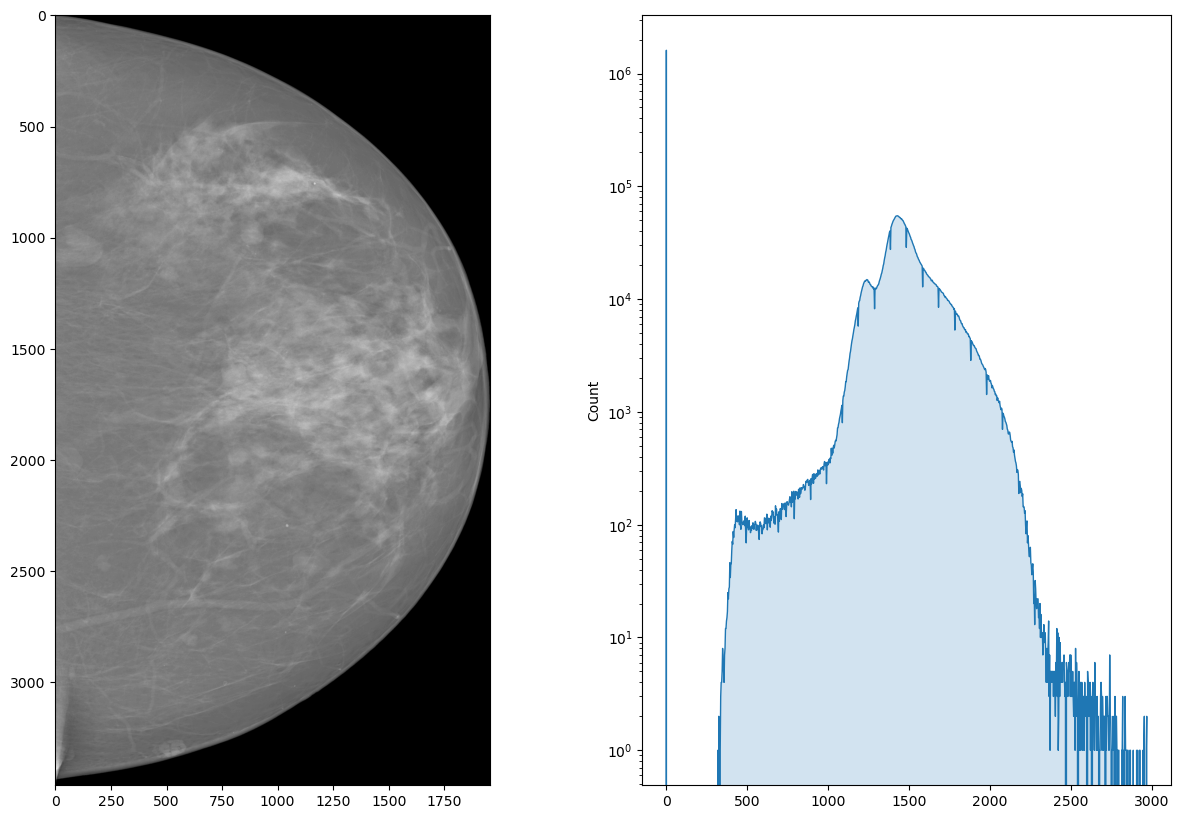

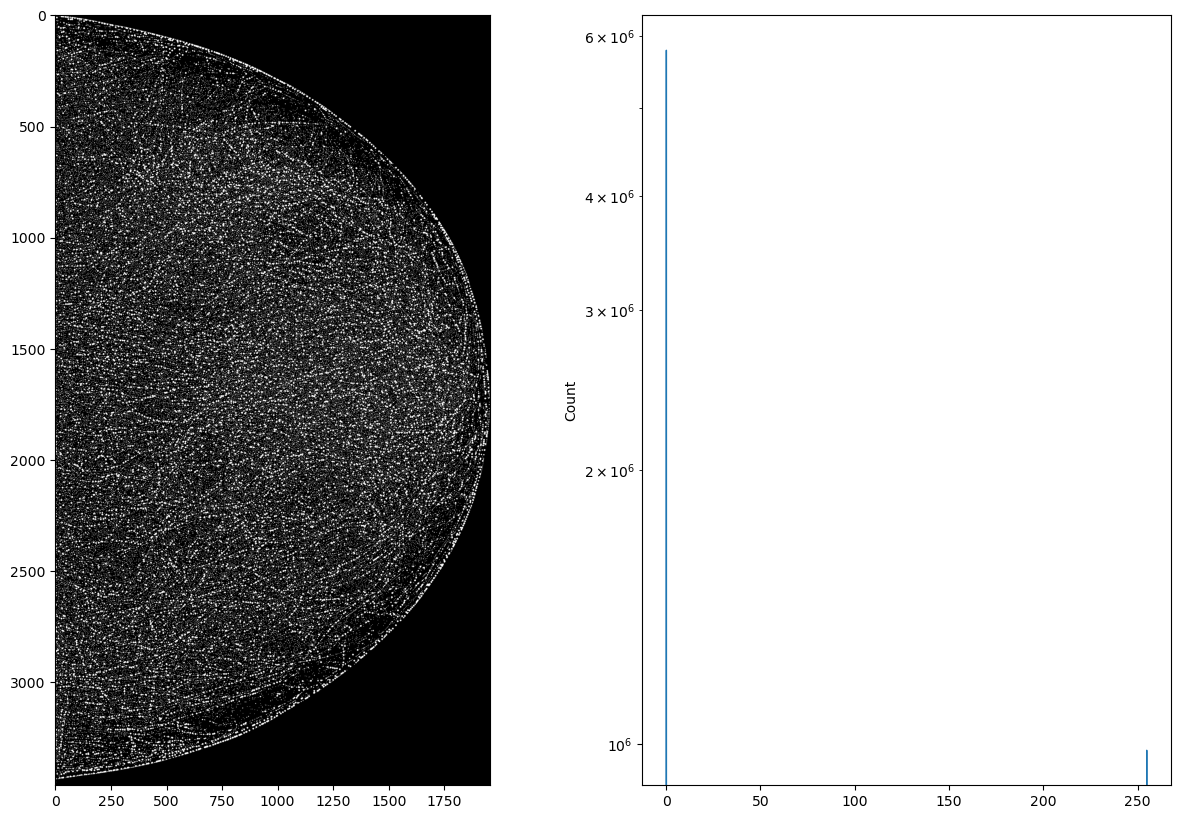

In [17]:
plot_img_hist(list_img[0])
plot_img_hist(img_mask)

### Test run of images subset

In [46]:
# img_list = np.asarray([i for i in range(db.df.shape[0])])
# img_list_sample =  np.random.choice(img_list,size=30,replace=False)
img_list_sample = np.asarray([111, 175,  12, 218, 205,  74, 210, 173, 189, 216,  73,  15, 258,
       106,  22, 226, 252, 135, 234, 290,  64, 152, 239, 201,  89,  52,
       122, 248, 280,  63])


In [47]:
list_imgs = [] 
for img_idx in tqdm(img_list_sample,total=img_list_sample.shape[0]):
    imgs_binary_blobs = {}
    img_mask,blob_list,no_blobs,no_blobs_filtered = get_image_blobs_2(db[img_idx]['img'])
    imgs_binary_blobs['img_index'] = img_idx
    blob_list_arr = np.array(blob_list.copy())
    blob_list_arr[:,2] = blob_list_arr[:,2]*sqrt(2)
    blob_list_arr[:,[0, 1]] = blob_list_arr[:,[1, 0]]
    TP, FP, FN = quick_circle_comparison(db[img_idx]['lesion_bboxes'],(blob_list_arr).astype(int),db[img_idx]['lesion_mask'])
    
    pred_se = cal_det_se(len(TP),FN)
    print(f'Sensitivity of image {img_idx}: {pred_se}')
    fp_pua = fp_per_unit_area(img_mask.shape,FP)
    print(f'FP per unit area (sqr cm): {fp_pua}')
    
    imgs_binary_blobs['Sensitivity'] = pred_se
    imgs_binary_blobs['FP_pua'] = fp_pua
    imgs_binary_blobs['No_blobs'] = no_blobs
    imgs_binary_blobs['No_filtered_blobs'] = no_blobs_filtered
    list_imgs.append(imgs_binary_blobs)

  0%|          | 0/30 [00:00<?, ?it/s]

No. of blobs: 125234
No. of blobs after hessian condition: 57351


  3%|▎         | 1/30 [02:28<1:11:53, 148.75s/it]

Sensitivity of image 111: 0.9166666666666666
FP per unit area (sqr cm): 220.53166284301378
No. of blobs: 51458
No. of blobs after hessian condition: 13717


  7%|▋         | 2/30 [02:58<36:37, 78.46s/it]   

Sensitivity of image 175: 1.0
FP per unit area (sqr cm): 156.97530463545908
No. of blobs: 54223
No. of blobs after hessian condition: 28064


 10%|█         | 3/30 [03:28<25:32, 56.74s/it]

Sensitivity of image 12: 0.8
FP per unit area (sqr cm): 282.8003875009162
No. of blobs: 191489
No. of blobs after hessian condition: 44175


 13%|█▎        | 4/30 [08:43<1:08:39, 158.44s/it]

Sensitivity of image 218: 0.875
FP per unit area (sqr cm): 124.73959514933924
No. of blobs: 109051
No. of blobs after hessian condition: 24827


 17%|█▋        | 5/30 [10:32<58:38, 140.72s/it]  

Sensitivity of image 205: 0.972027972027972
FP per unit area (sqr cm): 114.55582015625474
No. of blobs: 118712
No. of blobs after hessian condition: 36554


 20%|██        | 6/30 [12:51<56:05, 140.22s/it]

Sensitivity of image 74: 1.0
FP per unit area (sqr cm): 120.21746247331211
No. of blobs: 80820
No. of blobs after hessian condition: 30352


 23%|██▎       | 7/30 [13:48<43:20, 113.05s/it]

Sensitivity of image 210: 0.7884615384615384
FP per unit area (sqr cm): 187.0608087552186
No. of blobs: 61948
No. of blobs after hessian condition: 1026


 27%|██▋       | 8/30 [14:44<34:44, 94.76s/it] 

Sensitivity of image 173: 0.875
FP per unit area (sqr cm): 4.171901544430412
No. of blobs: 102143
No. of blobs after hessian condition: 30426


 30%|███       | 9/30 [16:04<31:33, 90.15s/it]

Sensitivity of image 189: 1.0
FP per unit area (sqr cm): 174.276398001296
No. of blobs: 140001
No. of blobs after hessian condition: 37316


 33%|███▎      | 10/30 [18:27<35:31, 106.57s/it]

Sensitivity of image 216: 0.7142857142857143
FP per unit area (sqr cm): 150.23456187289426
No. of blobs: 151458
No. of blobs after hessian condition: 47673


 37%|███▋      | 11/30 [21:25<40:38, 128.35s/it]

Sensitivity of image 73: 1.0
FP per unit area (sqr cm): 180.2516078320911
No. of blobs: 122601
No. of blobs after hessian condition: 6612


 40%|████      | 12/30 [24:11<41:53, 139.67s/it]

Sensitivity of image 15: 0.75
FP per unit area (sqr cm): 19.939139358351177
No. of blobs: 80406
No. of blobs after hessian condition: 25955


 43%|████▎     | 13/30 [25:28<34:13, 120.77s/it]

Sensitivity of image 258: 0.8888888888888888
FP per unit area (sqr cm): 127.30812216397896
No. of blobs: 89334
No. of blobs after hessian condition: 5919


 47%|████▋     | 14/30 [27:29<32:14, 120.90s/it]

Sensitivity of image 106: 1.0
FP per unit area (sqr cm): 16.82212045895998
No. of blobs: 87399
No. of blobs after hessian condition: 28266


 50%|█████     | 15/30 [28:56<27:39, 110.61s/it]

Sensitivity of image 22: 0.9230769230769231
FP per unit area (sqr cm): 125.49434273199672
No. of blobs: 163119
No. of blobs after hessian condition: 41491


 53%|█████▎    | 16/30 [32:31<33:08, 142.05s/it]

Sensitivity of image 226: 0.5
FP per unit area (sqr cm): 134.6450996133427
No. of blobs: 132306
No. of blobs after hessian condition: 53952


 57%|█████▋    | 17/30 [34:57<31:03, 143.33s/it]

Sensitivity of image 252: 0.9166666666666666
FP per unit area (sqr cm): 215.20763602973844
No. of blobs: 67227
No. of blobs after hessian condition: 12844


 60%|██████    | 18/30 [35:52<23:21, 116.80s/it]

Sensitivity of image 135: 0.7142857142857143
FP per unit area (sqr cm): 67.41954751196612
No. of blobs: 106096
No. of blobs after hessian condition: 23733


 63%|██████▎   | 19/30 [37:28<20:14, 110.38s/it]

Sensitivity of image 234: 0.8333333333333334
FP per unit area (sqr cm): 118.56594126750873
No. of blobs: 131044
No. of blobs after hessian condition: 62440


 67%|██████▋   | 20/30 [39:53<20:08, 120.82s/it]

Sensitivity of image 290: 1.0
FP per unit area (sqr cm): 249.75861374204953
No. of blobs: 116177
No. of blobs after hessian condition: 60701


 70%|███████   | 21/30 [41:42<17:36, 117.34s/it]

Sensitivity of image 64: 1.0
FP per unit area (sqr cm): 315.60299125707434
No. of blobs: 84319
No. of blobs after hessian condition: 27448


 73%|███████▎  | 22/30 [42:51<13:43, 102.89s/it]

Sensitivity of image 152: 1.0
FP per unit area (sqr cm): 152.38343111737518
No. of blobs: 85953
No. of blobs after hessian condition: 35385


 77%|███████▋  | 23/30 [43:58<10:44, 92.10s/it] 

Sensitivity of image 239: 1.0
FP per unit area (sqr cm): 215.57155189095627
No. of blobs: 163260
No. of blobs after hessian condition: 58496


 80%|████████  | 24/30 [47:40<13:05, 130.93s/it]

Sensitivity of image 201: 0.875
FP per unit area (sqr cm): 185.96901849765942
No. of blobs: 85370
No. of blobs after hessian condition: 29610


 83%|████████▎ | 25/30 [48:52<09:25, 113.20s/it]

Sensitivity of image 89: 1.0
FP per unit area (sqr cm): 159.93043693248222
No. of blobs: 130298
No. of blobs after hessian condition: 47033


 87%|████████▋ | 26/30 [50:57<07:46, 116.72s/it]

Sensitivity of image 52: 1.0
FP per unit area (sqr cm): 232.77585616807013
No. of blobs: 173127
No. of blobs after hessian condition: 47465


 90%|█████████ | 27/30 [55:09<07:52, 157.47s/it]

Sensitivity of image 122: 1.0
FP per unit area (sqr cm): 141.53310663842066
No. of blobs: 93145
No. of blobs after hessian condition: 15542


 93%|█████████▎| 28/30 [56:50<04:41, 140.53s/it]

Sensitivity of image 248: 0.8571428571428571
FP per unit area (sqr cm): 57.461433781292364
No. of blobs: 192370
No. of blobs after hessian condition: 63278


 97%|█████████▋| 29/30 [1:01:45<03:06, 186.76s/it]

Sensitivity of image 280: 1.0
FP per unit area (sqr cm): 186.90172054646263
No. of blobs: 68674
No. of blobs after hessian condition: 23834


100%|██████████| 30/30 [1:02:41<00:00, 125.37s/it]

Sensitivity of image 63: 0.75
FP per unit area (sqr cm): 144.17430713056197


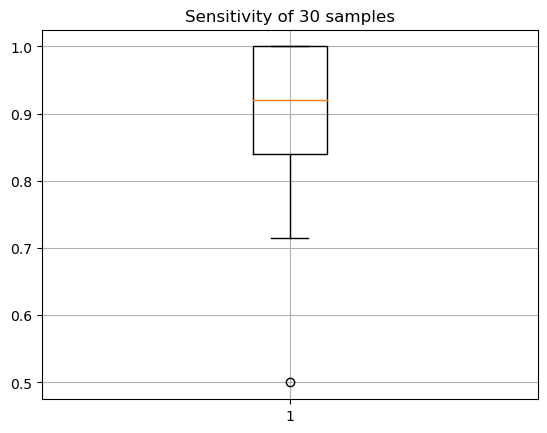

In [48]:
se_values = [ins['Sensitivity']for ins in list_imgs]
plt.boxplot(se_values)
plt.title('Sensitivity of 30 samples')
plt.grid('on')

In [54]:
print(np.asarray(se_values).mean())
print(np.asarray(se_values).std())

0.8983278758278759
0.12122875138608183


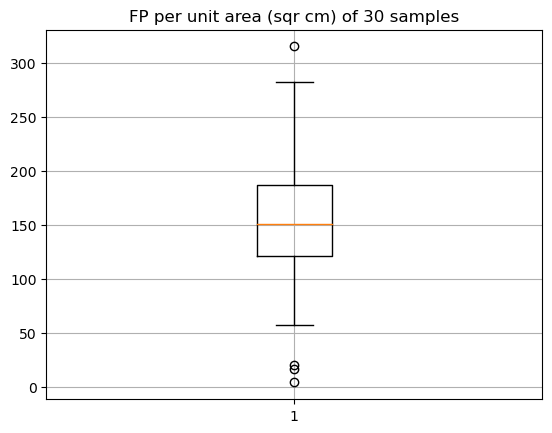

In [51]:
#fp_values = [30.909901284623576, 10.394047736381305,74.53340210271118,4.683384256286333,1.9745396263295723,3.4205948119680607,23.121054198602593,0.858674514666902,13.590545289117077,4.548411690608931,11.44532675171463,0.7802536954658975,8.896454882951506,1.6205186178142958,5.1301042633063005,4.4459818382810194,31.862220640220453,1.528085390293803,3.9626919300853216,56.922418975116756,74.89201789237066,7.83489492062152,27.935772460361054,12.111962100020257,11.594564969328971,22.73265521421926,5.820922509759327,0.36262608735698704,16.280833219844524,8.264114117760382]
fp_values = [ins['FP_pua']for ins in list_imgs]
plt.boxplot(fp_values)
plt.title('FP per unit area (sqr cm) of 30 samples')
plt.grid('on')

In [37]:
list_imgs[0]

{'img_index': 111,
 'Sensitivity': 0.875,
 'FP_pua': 0.875,
 'No_blobs': 125234,
 'No_filtered_blobs': 8058}

In [16]:
for im_index,image_results in enumerate(list_imgs):
    no_fp = image_results['FP']
    no_tp = len(image_results['TP'])
    no_fn = image_results['FN']
    print(f'Sensitivity of image {im_index}: {cal_det_se(no_tp,no_fn)}')
    fp_pua = fp_per_unit_area(image_results['img_mask'].shape,no_fp)
    print(f'FP per unit area (sqr cm): {fp_pua}')

Sensitivity of image 0: 0.918918918918919
FP per unit area (sqr cm): 5.090955622375085
Sensitivity of image 1: 0.8135593220338984
FP per unit area (sqr cm): 5.858145393029114
Sensitivity of image 2: 0.975
FP per unit area (sqr cm): 4.2022747401008615
Sensitivity of image 3: 0.7857142857142857
FP per unit area (sqr cm): 6.328092192310694
Sensitivity of image 4: 1.0
FP per unit area (sqr cm): 2.0379026310333495


In [14]:
list_imgs = [] 
for img_idx in range(10):
    imgs_binary_blobs = {}
    img_mask,blob_list = get_image_blobs(list_img[img_idx],hess_fil_type=2)
    imgs_binary_blobs['img_mask'] = img_mask
    imgs_binary_blobs['blobs_coords'] = blob_list
    
    blob_list_arr = np.array(blob_list.copy())
    blob_list_arr[:,2] = blob_list_arr[:,2]*sqrt(2)
    blob_list_arr[:,[0, 1]] = blob_list_arr[:,[1, 0]]
    TP, FP, FN = quick_circle_comparison(db[img_idx]['lesion_bboxes'],(blob_list_arr).astype(int),db[img_idx]['lesion_mask'])
    imgs_binary_blobs['TP'] = TP
    imgs_binary_blobs['FP'] = FP
    imgs_binary_blobs['FN'] = FN
    list_imgs.append(imgs_binary_blobs)
    

100%|██████████| 137365/137365 [01:44<00:00, 1311.47it/s]


No. of blobs: 137365
No. of blobs after hessian condition: 3917


100%|██████████| 113025/113025 [01:12<00:00, 1567.74it/s]


No. of blobs: 113025
No. of blobs after hessian condition: 2695


100%|██████████| 166294/166294 [02:19<00:00, 1194.95it/s]


No. of blobs: 166294
No. of blobs after hessian condition: 4418


100%|██████████| 89733/89733 [01:20<00:00, 1120.78it/s]


No. of blobs: 89733
No. of blobs after hessian condition: 2797


100%|██████████| 38925/38925 [00:08<00:00, 4410.35it/s]


No. of blobs: 38925
No. of blobs after hessian condition: 1120


100%|██████████| 25066/25066 [00:05<00:00, 4493.55it/s]


No. of blobs: 25066
No. of blobs after hessian condition: 809


100%|██████████| 65696/65696 [00:19<00:00, 3292.30it/s]


No. of blobs: 65696
No. of blobs after hessian condition: 1854


100%|██████████| 51036/51036 [00:13<00:00, 3686.94it/s]


No. of blobs: 51036
No. of blobs after hessian condition: 1491


100%|██████████| 120721/120721 [00:53<00:00, 2269.72it/s]


No. of blobs: 120721
No. of blobs after hessian condition: 2782


100%|██████████| 88851/88851 [00:44<00:00, 1990.81it/s]


No. of blobs: 88851
No. of blobs after hessian condition: 2480


In [15]:
for im_index,image_results in enumerate(list_imgs):
    no_fp = image_results['FP']
    no_tp = len(image_results['TP'])
    no_fn = image_results['FN']
    print(f'Sensitivity of image {im_index}: {cal_det_se(no_tp,no_fn)}')
    fp_pua = fp_per_unit_area(image_results['img_mask'].shape,no_fp)
    print(f'FP per unit area (sqr cm): {fp_pua}')

Sensitivity of image 0: 0.02702702702702703
FP per unit area (sqr cm): 11.810534488874902
Sensitivity of image 1: 0.0
FP per unit area (sqr cm): 9.848847058149383
Sensitivity of image 2: 0.0
FP per unit area (sqr cm): 12.60397135218303
Sensitivity of image 3: 0.0
FP per unit area (sqr cm): 7.377938250059613
Sensitivity of image 4: 0.0
FP per unit area (sqr cm): 9.431615482468395
Sensitivity of image 5: 0.0
FP per unit area (sqr cm): 7.464465821050641
Sensitivity of image 6: 0.0
FP per unit area (sqr cm): 11.799525076116481
Sensitivity of image 7: 0.0
FP per unit area (sqr cm): 10.681575270578591
Sensitivity of image 8: 0.0
FP per unit area (sqr cm): 12.117413362410943
Sensitivity of image 9: 0.0
FP per unit area (sqr cm): 10.360112021384806
